<a href="https://colab.research.google.com/github/dasom222g/learn-LLM/blob/main/01_2_LSTM%26GRU_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 과 GRU architecture
LSTM과 GRU 구조를 이해해보자.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec

In [ ]:
# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)

# 임의의 시계열 데이터 생성
def generate_time_series(n_samples=1000):
    time = np.arange(n_samples)
    # 사인파와 약간의 노이즈를 섞어서 시계열 데이터 생성
    data = np.sin(0.02 * time) + 0.5 * np.sin(0.05 * time) + 0.2 * np.random.randn(n_samples)
    return data, time

# 시계열 데이터를 시퀀스로 변환
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length): # 990번
        x = data[i:i+seq_length] # 10개의 배열
        y = data[i+seq_length] # index 10번째의 float
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

1000

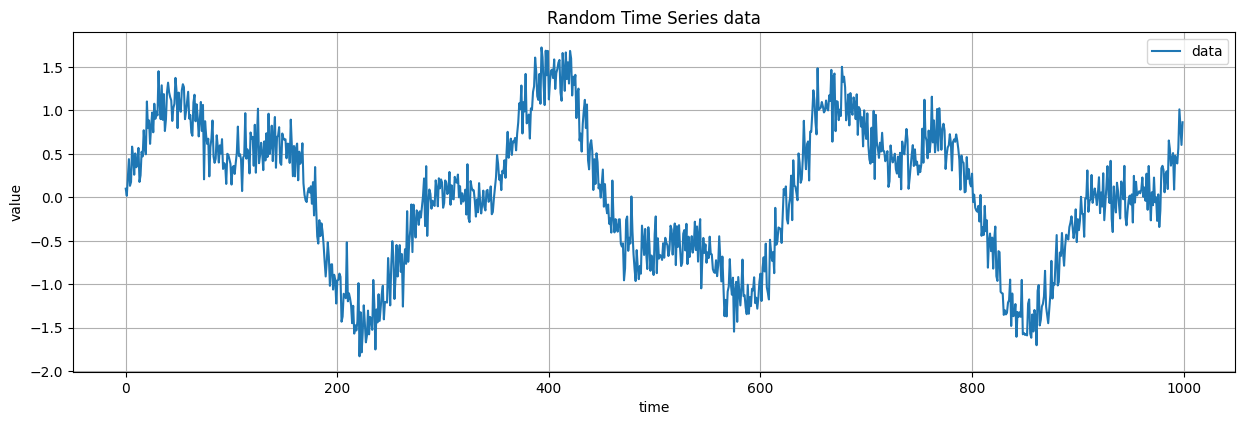

In [ ]:
# 데이터 생성
n_samples = 1000
seq_length = 10
data, time = generate_time_series(n_samples)
X, y = create_sequences(data, seq_length) # 문제와 정답

# 1부터 10까지 input을 주고 11번째의 정답 학습시키기
# 2부터 11까지 input 주고 12번째의 정답 학습시키기
# 990부터 999까지 input주고 1000번째의 정답 학습시키기

# 그래프 설정
plt.figure(figsize=(15, 10))
gs = GridSpec(3, 2, height_ratios=[2, 1, 1])

# 1. 전체 시계열 데이터 시각화
ax1 = plt.subplot(gs[0, :])
ax1.plot(time, data, label='data')
ax1.set_title('Random Time Series data')
ax1.set_xlabel('time')
ax1.set_ylabel('value')
ax1.legend()
ax1.grid(True)

len(data)

In [ ]:
X.shape, y.shape

((990, 10), (990,))

# LSTM

장단기 메모리 네트워크(Long Short-Term Memory, LSTM)는 순환 신경망(RNN)의 한 종류로, 기울기 소실 문제를 해결하기 위해 설계되었습니다. LSTM은 긴 시퀀스에서의 의존성을 더 잘 학습할 수 있어, 언어 모델링, 번역, 음성 인식 등의 작업에서 효과적입니다.


<br>

- 셀 상태: LSTM은 은닉 상태 외에 셀 상태를 추가로 사용하여 장기 정보를 저장하고 전달합니다.
- 게이트: 정보를 선택적으로 업데이트하고 전달하기 위해 입력 게이트, 삭제 게이트, 출력 게이트를 사용합니다.

구조
- 입력 게이트: 새로운 정보를 셀 상태에 얼마나 반영할지 결정합니다.
- 삭제 게이트: 이전 셀 상태에서 얼마나 정보를 유지할지 결정합니다.
- 출력 게이트: 현재 셀 상태에서 얼마나 정보를 출력할지 결정합니다.

- 입력 데이터 : cell.shape, hidden.shape, x.shape

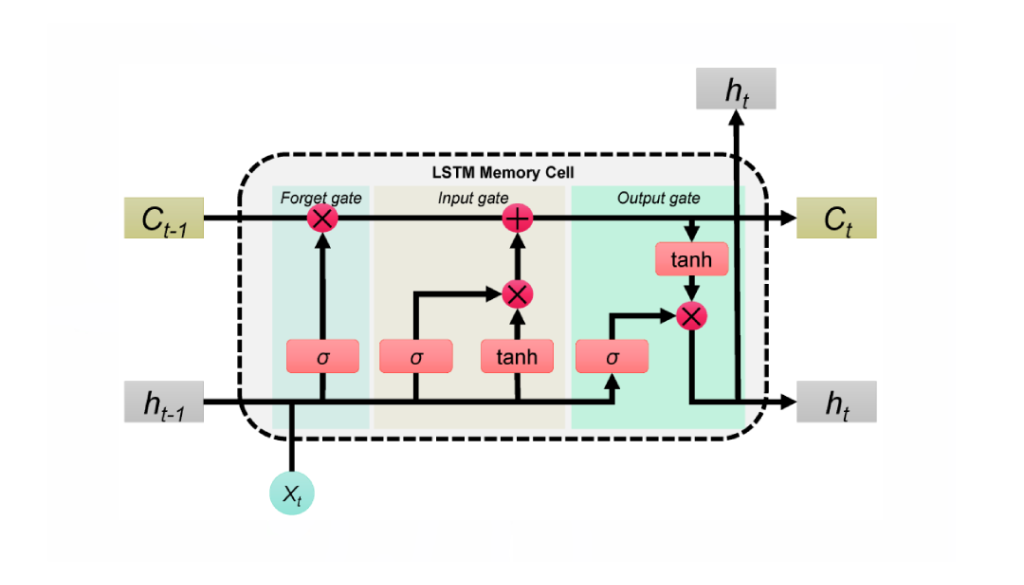

In [ ]:
# LSTM 모듈에 넣기 위해 데이터 전처리
# 입력 형태: [batch_size, seq_length, input_size]
X_tensor = torch.FloatTensor(X).unsqueeze(2)  # X 형태: [batch_size, seq_length] -> [batch_size, seq_length, 1]로 변환
y_tensor = torch.FloatTensor(y).unsqueeze(1)  # y 형태: [batch_size]에서 [batch_size, 1]로 변환

print(f"X 텐서 형태: {X_tensor.shape}")
print(f"y 텐서 형태: {y_tensor.shape}")

X 텐서 형태: torch.Size([990, 10, 1])
y 텐서 형태: torch.Size([990, 1])


In [ ]:
torch.FloatTensor(X)[0]

tensor([-0.2228, -0.0812, -0.0985,  0.0251,  0.1364,  0.3910,  0.2032, -0.0061,
         0.5820,  0.2291])

In [ ]:
torch.FloatTensor(X).unsqueeze(2)[0]

tensor([[-0.2228],
        [-0.0812],
        [-0.0985],
        [ 0.0251],
        [ 0.1364],
        [ 0.3910],
        [ 0.2032],
        [-0.0061],
        [ 0.5820],
        [ 0.2291]])

In [ ]:
# LSTM 모듈 파라미터 설정
input_size = 1
hidden_size = 32
num_layers = 1
batch_size = len(X_tensor) # 990

In [ ]:
# LSTM 모듈 생성
lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size,
               num_layers=num_layers,
               batch_first=True)

# 초기 은닉 상태와 셀 상태 생성 (모든 값 0으로 세팅)
h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

# LSTM 전방향 계산
lstm_out, (hn, cn) = lstm(X_tensor, (h0, c0)) #LSTM 실행
print(f"LSTM 출력 형태 (lstm_out): {lstm_out.shape}") # batch_size, seq_length, hidden_size
print(f"최종 은닉 상태 형태 (hn): {hn.shape}") # num_layers, batch_size, hidden_size
print(f"최종 셀 상태 형태 (cn): {cn.shape}")

# h0, c0
# [
#     [
#         [0, 0, 0, ... 32],
#         [0, 0, 0, ... 32],
#         ...
#         990
#     ]
# ]

LSTM 출력 형태 (lstm_out): torch.Size([990, 10, 32])
최종 은닉 상태 형태 (hn): torch.Size([1, 990, 32])
최종 셀 상태 형태 (cn): torch.Size([1, 990, 32])


In [ ]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM 통과
        out, _ = self.lstm(x)

        # 마지막 시퀀스 출력값만 사용
        out = self.fc(out[:, -1, :])
        return out

#GRU

게이트 순환 유닛(Gated Recurrent Unit, GRU)은 RNN의 변형된 형태로, LSTM과 유사하게 기울기 소실 문제를 해결하기 위해 설계되었습니다. GRU는 구조가 단순하여 계산 비용이 적으며, 언어 모델링, 번역, 음성 인식 등의 작업에서 효과적입니다.


- 업데이트 게이트: 새로운 정보와 이전 정보를 어떻게 조합할지 결정합니다.
- 리셋 게이트: 이전 정보를 얼마나 잊을지 결정합니다.

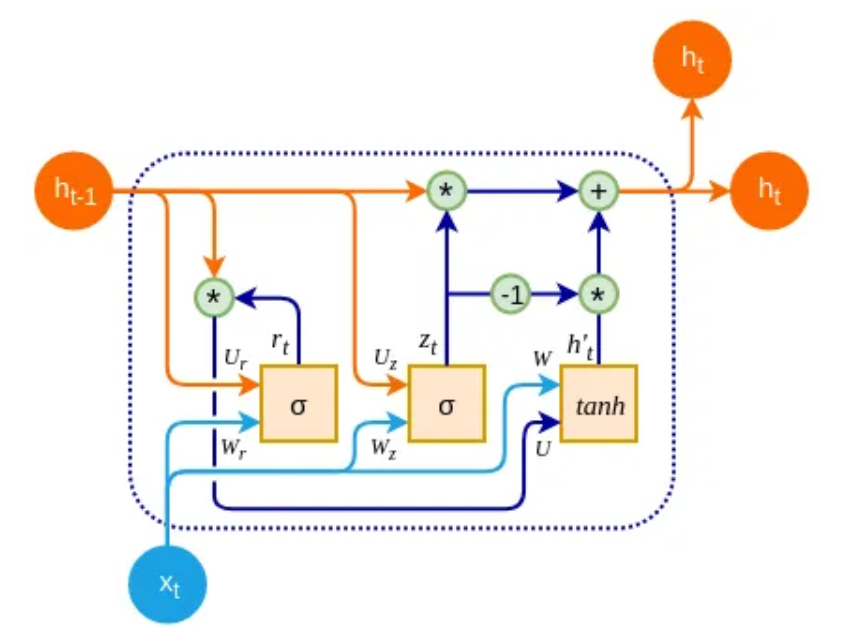

In [ ]:
# GRU 모듈에 넣기 위해 데이터 전처리
# 입력 형태: [batch_size, seq_length, input_size]
X_tensor = torch.FloatTensor(X).unsqueeze(2)  # X 형태: [batch_size, seq_length]에서 [batch_size, seq_length, 1]로 변환
y_tensor = torch.FloatTensor(y).unsqueeze(1)  # y 형태: [batch_size]에서 [batch_size, 1]로 변환

print(f"X 텐서 형태: {X_tensor.shape}")
print(f"y 텐서 형태: {y_tensor.shape}")

X 텐서 형태: torch.Size([990, 10, 1])
y 텐서 형태: torch.Size([990, 1])


In [ ]:
# GRU 모듈 파라미터 설정
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
batch_size = len(X_tensor)

In [ ]:
# GRU 모듈 생성
gru = nn.GRU(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             batch_first=True)

# 초기 은닉 상태 생성 (GRU는 셀 상태가 없음)
h0 = torch.zeros(num_layers, batch_size, hidden_size)

# GRU 전방향 계산
gru_out, hn = gru(X_tensor, h0)

print(f"GRU 출력 형태 (gru_out): {gru_out.shape}")
print(f"최종 은닉 상태 형태 (hn): {hn.shape}")

GRU 출력 형태 (gru_out): torch.Size([990, 10, 32])
최종 은닉 상태 형태 (hn): torch.Size([1, 990, 32])


In [ ]:
# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # GRU 통과
        out, _ = self.gru(x)

        # 마지막 시퀀스 출력값만 사용
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# 모델 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # 순전파
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses

# 모델 평가 함수
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predictions = [] # 단기예측 (10개보고 1개 예측)
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            predictions.extend(outputs.numpy())
            actuals.extend(y_batch.numpy())

    avg_test_loss = test_loss / len(test_loader)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    print(f'Test Loss: {avg_test_loss:.4f}, RMSE: {rmse:.4f}')
    return predictions, actuals

=== LSTM 모델 학습 시작 ===
Epoch [10/100], Loss: 0.0181
Epoch [20/100], Loss: 0.0169
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0166
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0164
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0168
Epoch [90/100], Loss: 0.0163
Epoch [100/100], Loss: 0.0166
Test Loss: 0.0156, RMSE: 0.1236

=== GRU 모델 학습 시작 ===
Epoch [10/100], Loss: 0.0164
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0161
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0165
Epoch [70/100], Loss: 0.0163
Epoch [80/100], Loss: 0.0165
Epoch [90/100], Loss: 0.0159
Epoch [100/100], Loss: 0.0165
Test Loss: 0.0154, RMSE: 0.1225


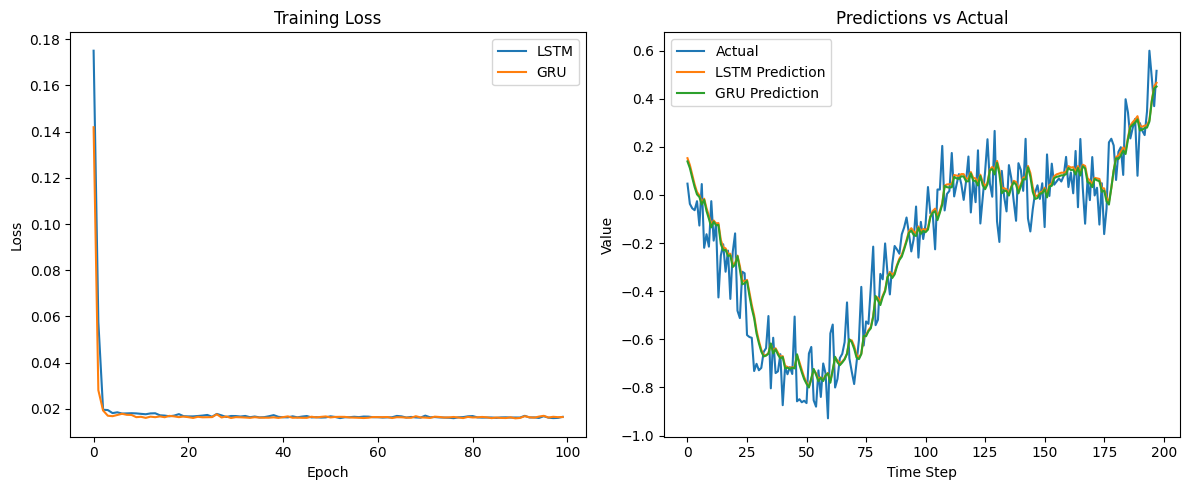

In [ ]:
def main():
    # 데이터 생성
    data, _ = generate_time_series(1000)

    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # 시퀀스 생성
    seq_length = 10
    X, y = create_sequences(data_normalized, seq_length)

    # 학습/테스트 데이터 분할
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # PyTorch 텐서로 변환
    X_train = torch.FloatTensor(X_train).unsqueeze(2)  # (배치 크기, 시퀀스 길이, 입력 차원)
    y_train = torch.FloatTensor(y_train).unsqueeze(1)  # (배치 크기, 출력 차원)
    X_test = torch.FloatTensor(X_test).unsqueeze(2)
    y_test = torch.FloatTensor(y_test).unsqueeze(1)

    # 데이터 로더 생성
    batch_size = 32
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 모델 하이퍼파라미터 설정
    input_size = 1
    hidden_size = 32
    num_layers = 2
    output_size = 1

    # LSTM 모델 초기화 및 학습
    lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

    print("=== LSTM 모델 학습 시작 ===")
    lstm_losses = train_model(lstm_model, train_loader, criterion, optimizer, num_epochs=100) # 학습
    lstm_predictions, lstm_actuals = evaluate_model(lstm_model, test_loader, criterion) # 평가

    # GRU 모델 초기화 및 학습
    gru_model = GRUModel(input_size, hidden_size, num_layers, output_size)
    optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

    print("\n=== GRU 모델 학습 시작 ===")
    gru_losses = train_model(gru_model, train_loader, criterion, optimizer, num_epochs=100) # 학습
    gru_predictions, gru_actuals = evaluate_model(gru_model, test_loader, criterion) # 평가

    # 학습 손실 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lstm_losses, label='LSTM')
    plt.plot(gru_losses, label='GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # 예측 결과 시각화
    plt.subplot(1, 2, 2)
    plt.plot(lstm_actuals, label='Actual')
    plt.plot(lstm_predictions, label='LSTM Prediction')
    plt.plot(gru_predictions, label='GRU Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Predictions vs Actual')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()